# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [1]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint

## Data Importing

In [2]:
# # loop over all files and put them into a dataframe
# from functions_importing import get_data


In [3]:
# filepath = r"C:\Users\mebar\Documents\LHL-DataSci\Projects\midterm_project_housing_prices\Data"

In [4]:
# raw_data = get_data(filepath)
# raw_data.head()

In [5]:
# raw_data.to_pickle('pickles/raw_data.pkl')

In [6]:
raw_data = pd.read_pickle('pickles/raw_data.pkl')

## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [7]:
# from functions_importing import extract_tags

In [8]:
# with_tags = extract_tags(raw_data)

In [9]:
# with_tags.to_pickle('pickles/with_tags.pkl')

First remove duplicates:

In [10]:
data_dupes = pd.read_pickle('pickles/with_tags.pkl')

data = data_dupes.drop_duplicates(subset=['property_id'])
print('size of raw data:', data_dupes.shape)
print('size after removing duplicates:', data.shape)

size of raw data: (8159, 194)
size after removing duplicates: (1795, 194)


Empty columns: 

In [11]:
data.loc[:,['descrip_name','descrip_baths_1qtr','flags_is_new_construction','flags_is_for_rent','flags_is_subdivision','flags_is_contingent',
            'flags_is_pending','flags_is_plan','flags_is_coming_soon','open_houses']].isna().value_counts()

descrip_name  descrip_baths_1qtr  flags_is_new_construction  flags_is_for_rent  flags_is_subdivision  flags_is_contingent  flags_is_pending  flags_is_plan  flags_is_coming_soon  open_houses
True          True                True                       True               True                  True                 True              True           True                  True           1795
Name: count, dtype: int64

In [12]:
# drop empty columns, old tags column
data = data.drop(['descrip_name','descrip_baths_1qtr','flags_is_new_construction','flags_is_for_rent','flags_is_subdivision','flags_is_contingent',
            'flags_is_pending','flags_is_plan','flags_is_coming_soon','open_houses',],axis=1)

'community', 'flags_is_foreclosure', 'courtyard_entry', 'well_water' and 'open_house' are basically empty; flags_is_new_listing and status have all the same value, so drop them as well.

In [13]:
print('community: rows with data:',len(data[~data['community'].isna()]))
data['flags_is_new_listing'].value_counts()

community: rows with data: 1


flags_is_new_listing
False    1704
Name: count, dtype: int64

In [14]:
data = data.drop(['community','flags_is_foreclosure','flags_is_new_listing','status','open_house','courtyard_entry','well_water'],axis=1)

None of these columns contain anything that's interesting for regression, so they are being dropped.

In [15]:
display(data['products'].value_counts())
display(data['lead_attributes'].value_counts())

products
{'brand_name': 'essentials'}         1078
{'brand_name': 'basic_opt_in'}        477
{'brand_name': 'advantage_brand'}     130
{'brand_name': 'advantage_pro'}         2
Name: count, dtype: int64

lead_attributes
{'show_contact_an_agent': True}     1775
{'show_contact_an_agent': False}      20
Name: count, dtype: int64

In [16]:
data = data.drop(['products','lead_attributes'],axis=1)

There's a missing value in the cities column, for a farm/ranch. Which means that 'none' is probably valid, so we're imputing it as a string instead of a NoneType.

In [17]:
data[data['location_city'].isna()][['location_state','location_city','ranch','farm']]

,location_state,location_city,ranch,farm
5624,Ohio,None,1.0,1.0


In [18]:
# filling 
data['location_city'] = data['location_city'].fillna('None')

# dropping farm and ranch, as we aren't using them
data = data.drop(['farm','ranch'],axis=1)

Given the above statement that the list price is too close to the sold price, it can be used to fill in missing values in the sold price column.

In [19]:
print('missing values in "sold price":',len(data[data['descrip_sold_price'].isna()]))

missing values in "sold price": 320


In [20]:
data['descrip_sold_price'] = data['descrip_sold_price'].fillna(data['list_price'])

However, rows with no price info at all will need to be dropped, and we can now drop list_price.

In [21]:
print('no price info:',len(data[(data['descrip_sold_price'].isna()) & (data['list_price'].isna())]))

no price info: 35


In [22]:
# drop rows that still have NaNs 
data = data.dropna(subset=['descrip_sold_price']).drop('list_price',axis=1)

We don't think we are going to be using the price reduction data, and flags_is_price_reduced is broken, showing True _and_ False with numeric values in the price_reduced_amount column, so those columns are being dropped. Database internal IDs are not needed. The list date is redundant to the sold date, so it is being dropped. 

In [23]:
data = data.drop(['price_reduced_amount','flags_is_price_reduced','property_id','listing_id','list_date'],axis=1)

The hoa tags also have issues, and are mostly empty, so they are being dropped. 

In [24]:
print('has any hoa tag:',len(data[(data['hoa']>0)|(data['low_hoa']>0)|(data['no_hoa']>0)]))
print('yes hoa AND no hoa:',len(data[(data['hoa']>0) & (data['no_hoa']>0)]))

has any hoa tag: 64
yes hoa AND no hoa: 3


In [25]:
data = data.drop(['hoa','low_hoa','no_hoa'],axis=1)

It is unclear what the floor_plan tag is related to, as all buildings by definition have a floor plan. Given that this tag is apparently optional it cannot be used to draw any conclusions. The open_floor_plan tag only occurs alongside the floor_plan tag, but also probably can't be used to draw conclusions, given the many missing values. A lack of open floor plan tag doesn't necessarily mean the property _isn't_ open plan. We are dropping those columns.

In [26]:
print('floor plan:',len(data[data['floor_plan']>0]))
print('open + floor:',len(data[(data['open_floor_plan']>0) & (data['floor_plan']>0)]))

floor plan: 233
open + floor: 133


In [27]:
data = data.drop(['floor_plan','open_floor_plan'],axis=1)

We have decided we are not going to work with the tags dealing with tags related to features of the surrounding area unless we have time left over, so those are going to be dropped for now.

In [28]:
skipped_feat = ['community_outdoor_space','recreation_facilities','rv_or_boat_parking','trails','shopping','waterfront','beach',
'spa_or_hot_tub','horse_facilities','pond','swimming_pool','wooded_land','community_swimming_pool','tennis_court',
'tennis','community_park','clubhouse','park','library','community_center','community_golf','community_tennis_court',
'community_clubhouse','playground','lake','golf_course','volleyball','rv_parking','river_access','basketball_court',
'basketball','community_gym','marina','greenbelt','community_spa_or_hot_tub','community_horse_facilities','soccer',                          
'community_boat_facilities','indoor_basketball_court','baseball','horse_stables','horse_property','equestrian',
'boat_dock','horse_stables','horse_property','equestrian','rv_parking','rv_or_boat_parking','boat_dock',
'community_elevator','elevator','outbuilding','detached_guest_house','guest_house','hill_or_mountain_view','ocean_view',
'city_view','lake_view','river_view','water_view','view','mountain_view','views','golf_course_view','fruit_trees','greenhouse',
'senior_community','groundscare','maintenance','gated_community','community_security_features','medicalcare',
'disability_features','handicap_access','big_lot','corner_lot','golf_course_lot_or_frontage','big_yard','efficient',
'energy_efficient','beautiful_backyard','fixer_upper','investment_opportunity',
]

In [29]:
data = data.drop(skipped_feat,axis=1)

Given the output below, it looks like 'subtype' and 'type' are reversed, so we have decided to group properties first based on 'subtype' and then by type. This will eliminate the tiny categories. 

In [30]:
display(data[['descrip_type','descrip_sub_type']].value_counts())
display(data['descrip_type'].value_counts())

descrip_type                 descrip_sub_type
condos                       condo               182
townhomes                    townhouse           124
apartment                    condo                 4
condo_townhome_rowhome_coop  townhouse             1
duplex_triplex               townhouse             1
Name: count, dtype: int64

descrip_type
single_family                  1188
condos                          182
townhomes                       124
multi_family                    118
land                             82
mobile                           43
condo                            11
apartment                         4
other                             2
duplex_triplex                    1
condo_townhome_rowhome_coop       1
Name: count, dtype: int64

We are also going to combine 'condos' into the rest of the 'condo' category because that seems like an error. Anything without a value already is going to be assigned other/unknown, as other is the smallest category and there are very few blank values. 

In [31]:
# create new column
data['property_type'] = 'other_unknown'

# assigning values to the new column based on the relevant type column
# -> based on type:
data.loc[data['descrip_type']=='single_family','property_type'] = 'single_family'
data.loc[data['descrip_type']=='multi_family','property_type'] = 'multi_family'
data.loc[data['descrip_type']=='land','property_type'] = 'land'
data.loc[data['descrip_type']=='mobile','property_type'] = 'mobile'
data.loc[data['descrip_type']=='condo','property_type'] = 'condo'
data.loc[data['descrip_type']=='other','property_type'] = 'other_unknown'

# -> based on subtype:
data.loc[data['descrip_sub_type']=='condo','property_type'] = 'condo'
data.loc[data['descrip_sub_type']=='townhouse','property_type'] = 'townhouse'

# drop old columns
data = data.drop(['descrip_type','descrip_sub_type'],axis=1)

In [32]:
data['property_type'].value_counts()

property_type
single_family    1188
condo             197
townhouse         126
multi_family      118
land               82
mobile             43
other_unknown       6
Name: count, dtype: int64

In order to use the categories with a model, it needs to be in a numberical form, so the new column needs to be OneHotEncoded. 

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
# create dataframe with names of each category 
hotspec = OneHotEncoder(sparse_output=False,min_frequency=5)
type_encode  = pd.DataFrame(data=(hotspec.fit_transform(data[['property_type']])),
             columns=(hotspec.get_feature_names_out()))

# reset main index so the merge works properly
data = data.reset_index().drop('index',axis=1)

# merge new columns onto the main table
data = pd.concat([data,type_encode],axis=1)

In [35]:
type_encode.keys()

Index(['property_type_condo', 'property_type_land', 'property_type_mobile',
       'property_type_multi_family', 'property_type_other_unknown',
       'property_type_single_family', 'property_type_townhouse'],
      dtype='object')

I use the property_type column later, so it needs to stay for now.<p>
Where the descrip_stories column is empty we can fill some of them in with the single_story or two_or_more_stories tags. 

In [36]:
print('single story tag, no descrip:',len(data[(data['descrip_stories'].isna())&(data['two_or_more_stories'].isna())&(data['single_story']>0)]))
print('2+ tag, no descrip:',len(data[(data['descrip_stories'].isna())&(data['two_or_more_stories']>0)&(data['single_story'].isna())]))
print('none of them:',len(data[(data['descrip_stories'].isna())&(data['two_or_more_stories'].isna())&(data['single_story'].isna())]))
display(data['descrip_stories'].value_counts())

single story tag, no descrip: 27
2+ tag, no descrip: 37
none of them: 333


descrip_stories
1.0     716
2.0     541
3.0      92
4.0       7
6.0       4
10.0      2
8.0       1
Name: count, dtype: int64

While not perfect, most multistory homes are two stories (84%), so it's reasonably likely that would be the number. <p>
Missing values for descrip stories will be filled with:<br>
1 for available single story tag<br>
2 for available two or more tag<br>
0 for missing all of them

In [37]:
# fill empty values with 0
data.loc[:,'descrip_stories'] = data['descrip_stories'].fillna(0)

# fill 1 for single story using list of indexes
data.loc[((data[(data['descrip_stories']==0)&   # where descrip is empty and
                (data['single_story']>0)        # single story is valid
                ].index).tolist()),'descrip_stories'] = 1

# # fill 2 for multistory using list of indexes
data.loc[((data[(data['descrip_stories']==0)&   # where descrip is empty and
                (data['two_or_more_stories']>0) # multistory is valid
                ].index).tolist()),'descrip_stories'] = 2

# drop redundant columns
data = data.drop(['single_story','two_or_more_stories'],axis=1)

In [38]:
import matplotlib
import matplotlib.pyplot as plt

Based on the output of these graphs - 

Text(0.5, 1.0, 'home size')

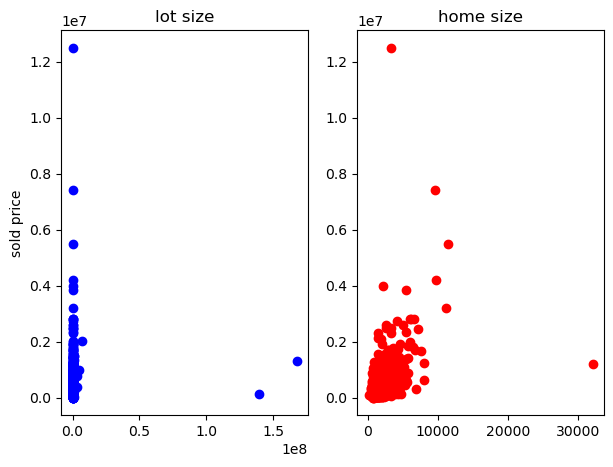

In [39]:
a = data['descrip_sold_price']
b = data['descrip_sqft']
d = data['descrip_lot_sqft']

plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.scatter(d,a,color='blue')
plt.title('lot size')
plt.ylabel('sold price')

plt.subplot(1,2,2)
plt.scatter(b,a,color='red')
plt.title('home size')

-we know we have some crazy outliers that need to be dealt with before we can do any imputing later on, so this has gotten moved up here. Those three outliers may be valid, but they are skewing the data, so we are removing them. 

In [40]:
data = data.drop((data[data['descrip_sold_price']>12000000]).index)
data = data.drop((data[data['descrip_sqft']>30000]).index)
data = data.drop((data[data['descrip_lot_sqft']>130000000]).index)

Text(0.5, 1.0, 'home size')

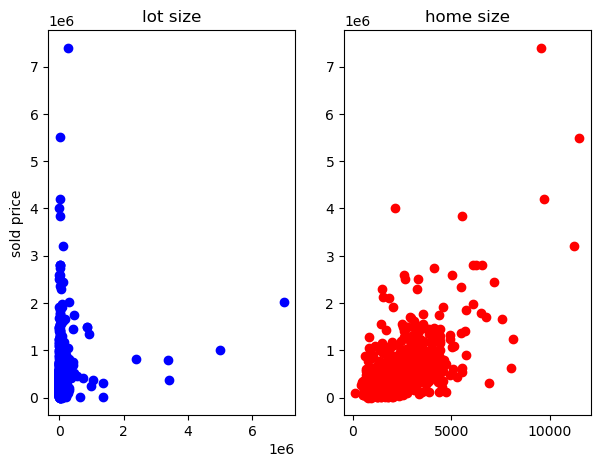

In [41]:
a = data['descrip_sold_price']
b = data['descrip_sqft']
d = data['descrip_lot_sqft']

plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.scatter(d,a,color='blue')
plt.title('lot size')
plt.ylabel('sold price')

plt.subplot(1,2,2)
plt.scatter(b,a,color='red')
plt.title('home size')

### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

_(could not use .loc to only fillna the expanded tags columns, so those are going to have to be applied case by case.)_

Garage tags are cumulative; anything with a garage_3_or_more tag will also have a garage_1_or_more and garage_2_or_more. These seem to be refering to the total car capacity, as the descrip_garage column can be more than 3, but if the garage_3_or_more tag is present it will be at **least** 3. Some properties with garage_n_or_more tags have blank descrip_garage values, so that should be filled in and used as the only garage column.

In [42]:
display(data.loc[[0,6,244,468],['garage_1_or_more','garage_2_or_more','garage_3_or_more','descrip_garage']])

print('only descrip filled in:',len(data[(data['garage_1_or_more'].isna())&(data['garage_2_or_more'].isna())&
                                         (data['garage_3_or_more'].isna())&(data['descrip_garage']>0)]))
print('missing descrip:',len(data[(data['descrip_garage'].isna())&((data['garage_1_or_more']>0)|(data['garage_2_or_more']>0)|(data['garage_3_or_more']>0))]))

print('inside the rows missing descrip:')
display(data[((data['garage_1_or_more']>0)|(data['garage_2_or_more']>0)|(data['garage_3_or_more']>0))&(data['descrip_garage'].isna())][['garage_1_or_more','garage_2_or_more','garage_3_or_more']].sum())

,garage_1_or_more,garage_2_or_more,garage_3_or_more,descrip_garage
0,1.0,NaN,NaN,1.0
6,NaN,NaN,NaN,NaN
244,1.0,1.0,1.0,3.0
468,1.0,1.0,1.0,6.0


only descrip filled in: 6
missing descrip: 75
inside the rows missing descrip:


garage_1_or_more    75.0
garage_2_or_more     0.0
garage_3_or_more     0.0
dtype: float64

Since all the rows with an empty descrip_garage value only have garage_1 tags, fill descip_garage with 1 for those rows. 

In [43]:
# fillna(0) the relevant columns
data.loc[:,'garage_1_or_more'] = data['garage_1_or_more'].fillna(0)
data.loc[:,'descrip_garage'] = data['descrip_garage'].fillna(0)

# using list of indexes to select rows to fill
data.loc[((data[(data['descrip_garage']==0.0)&  # nothing in descrip column and
                (data['garage_1_or_more']>0     # valid value in garage_1 column
                 )].index).tolist()),'descrip_garage'] = 1

carport and private_parking do not count as garages, as shown below, but they are still parking spaces assigned to the owner of the property specifically, which can be very important inside a city. 

In [44]:
display(data[                   
    (data['garage_2_or_more']==1.0)&   # two car garage and
    (data['carport']==1.0)              # has a carport
    ][['descrip_garage','carport','garage_2_or_more']].head(1))

display(data[
    (data['descrip_garage']==0.0)&   # no garage space
    (data['private_parking']==1.0)   # has priavate parking
    ][['descrip_garage','private_parking']].head(1))

,descrip_garage,carport,garage_2_or_more
24,2.0,1.0,1.0


,descrip_garage,private_parking
1353,0.0,1.0


We can make a has_parking column with binary 0/1 for whether a property is marked as having any amount of garage space, a carport, and/or private parking. 

In [45]:
# create new column, default value 0
data['has_parking'] = 0.0

# assign 1s in the appropriate rows using list of indexes
data.loc[((data[
    (data['carport']==1.0)|         # has a carport or
    (data['private_parking']==1.0)| # has private parking or
    (data['descrip_garage']>0)      # has any size garage(s) 
    ].index).tolist()),'has_parking'] = 1.0

In [46]:
# drop the now redundant columns, rename the updated one
data = data.drop(['garage_1_or_more','garage_2_or_more','garage_3_or_more','carport','private_parking'],axis=1)
data = data.rename(columns={'descrip_garage': 'garage_car_spaces'})

According to Google, forced air and central heat are both types of heating, just with slightly different mechanisms, so those can be combined into one column 'heating' and then dropped.

In [47]:
print('properties with either forced air or central heat:')
print(len(data[(data['forced_air']>0) | (data['central_heat']>0)]))

properties with either forced air or central heat:
1009


In [48]:
# fillna(0) the relevant columns
data.loc[:,'central_heat'] = data['central_heat'].fillna(0)
data.loc[:,'forced_air'] = data['forced_air'].fillna(0)

# create heating column, default value 0
data['heating'] = 0.0

# assign the rows with those tags a 1 using list index
data.loc[((data[(data['central_heat']>0)|   # valid value for central heat or
                (data['forced_air']>0)      # valid value for forced air
                ].index).tolist()),'heating'] = 1.0

#drop old columns
data = data.drop(['central_heat','forced_air'],axis=1)

solar_panels is completely redundant with solar_system and never occurs on its own; renaming solar_system 'solar_power' and dropping solar_panel. 

In [49]:
print('solar system or panels:',len(data[(data['solar_system']>0) | (data['solar_panels']>0)]))
print('both:',len(data[(data['solar_system']>0) & (data['solar_panels']>0)]))
print('only panels:',len(data[(data['solar_system']==0) & (data['solar_panels']>0)]))

solar system or panels: 33
both: 18
only panels: 0


In [50]:
# fillna(0) the relevant column
data.loc[:,'solar_system'] = data['solar_system'].fillna(0)

data = data.rename(columns={'solar_system': 'solar_power'})
data = data.drop('solar_panels',axis=1)

There are four tags for porches, which are going to be combined into one 'porch' column.

In [51]:
# create porch column, default value 0
data['porch'] = 0.0

# assign the rows with those tags a 1 using list of indexes
data.loc[((data[(~data['front_porch'].isna())|      # where front porch isn't null or
                (~data['large_porch'].isna())|      # where large porch isn't null or
                (~data['screen_porch'].isna())|     # where screen porch isn't null or
                (~data['wrap_around_porch'].isna()) # where wrap around porch isn't null
                ].index).tolist()),'porch'] = 1.0

# drop old columns
data = data.drop(['front_porch','large_porch','screen_porch','wrap_around_porch'],axis=1)

While some properties, like apartments, might not have a dedicated laundry room, laundry rooms generally have washers and dryers. So these will be combined into 'laundry_facilities'.

In [52]:
data[(data['washer_dryer']==1.0)|(data['laundry_room']==1.0)][['washer_dryer','laundry_room']].sum()

washer_dryer    494.0
laundry_room    495.0
dtype: float64

In [53]:
# create Laundry_facilities column, default value 0
data['laundry_facilities'] = 0.0

# assign the rows with those tags a 1 using list of indexes
data.loc[((data[(~data['washer_dryer'].isna())| # where washer/dryer isn't null or
                (~data['laundry_room'].isna())  # where laundry room isn't null
                ].index).tolist()),'laundry_facilities'] = 1.0

# drop old columns 
data = data.drop(['washer_dryer','laundry_room'],axis=1)

Kitchen and ceiling features:<p>
We are going to handle this in two ways:  the creation of 'notable_kitchen' for any tag pretaining to kitchen, and 'notable_ceiling' for the ceiling ones, and then a 'recently_updated' column with a max value of 2 based on the presence of 'updated_kitchen' and 'new_roof'. Without interior design knowledge there is no way to meaninfully rank the various types of kitchen or ceiling, but their inclusion presumably means they are desirable. <p>
_Note: ceilings are interior and roofs are exterior, so the 'new_roof' column is not part of the notable_ceiling aggregate._

In [54]:
# create new columns, default values all 0
data[['notable_kitchen','notable_ceiling','recently_updated']] = 0.0

# assign each column 1s in the appropriate rows using list of indexes
# -> kitchens 
data.loc[((data[(~data['updated_kitchen'].isna())|  # where updated kitchen isn't null or
                (~data['modern_kitchen'].isna())|   # where modern kitchen isn't null or
                (~data['large_kitchen'].isna())|    # where large kitchen isn't null or
                (~data['granite_kitchen'].isna())|  # where granite kitchen isn't null or
                (~data['open_kitchen'].isna())|     # where open kitchen isn't null or
                (~data['gourmet_kitchen'].isna())|  # where gourmet kitchen isn't null or
                (~data['kitchen_island'].isna())|   # where kitchen island isn't null or
                (~data['outdoor_kitchen'].isna())|  # where outdoor kitchen isn't null or
                (~data['white_kitchen'].isna())|    # where white kitchen isn't null or
                (~data['two_kitchen'].isna())       # where two kitchen isn't null
                ].index).tolist()),'notable_kitchen'] = 1.0

# -> ceilings
data.loc[((data[(~data['high_ceiling'].isna())|         # where high ceiling isn't null or
                (~data['coffer_ceiling'].isna())|       # where coffer ceiling isn't null or
                (~data['cathedral_ceiling'].isna())|    # where cathedral ceiling isn't null or
                (~data['vaulted_ceiling'].isna())       # where vaulted ceiling isn't null 
                ].index).tolist()),'notable_ceiling'] = 1.0

# -> recent updates
# (has both)
data.loc[((data[(~data['new_roof'].isna())&         # where new roof isn't null and
                (~data['updated_kitchen'].isna())   # where updated kitchen isn't null 
                ].index).tolist()),'recently_updated'] = 1.0
# only kitchen
data.loc[((data[(data['new_roof'].isna())&          # where new roof is null and
                (~data['updated_kitchen'].isna())   # where updated kitchen isn't null  
                ].index).tolist()),'recently_updated'] = 1.0
# only roof 
data.loc[((data[(~data['new_roof'].isna())&         # where new roof isn't null and
                (data['updated_kitchen'].isna())    # where updated kitchen isn null 
                ].index).tolist()),'recently_updated'] = 1.0

# drop old columns
data = data.drop(['updated_kitchen','modern_kitchen','large_kitchen','open_kitchen','granite_kitchen','gourmet_kitchen',
            'kitchen_island','outdoor_kitchen','white_kitchen','two_kitchen','high_ceiling','coffer_ceiling',
            'cathedral_ceiling','vaulted_ceiling','new_roof'],axis=1)

We have decided that we are going to consider 'media_room', 'theater_room' and 'game_room' the same for our purposes, as they logically are essentially the same and there are very few of them in the overall dataset. 

In [55]:
# create new column, default values 0
data['multimedia_room'] = 0.0

# assign the rows with those tags a 1 using list of indexes
data.loc[((data[(~data['media_room'].isna())|   # where media room isn't null or
                (~data['theater_room'].isna())| # where theater room isn't null or
                (~data['game_room'].isna())     # where game room isn't null 
                ].index).tolist()),'multimedia_room'] = 1.0

# drop old columns
data = data.drop(['media_room','theater_room','game_room'],axis=1)

Going to collapse fenced_yard, private_backyard and fenced_courtyard into 'enclosed_yard'; given that the courtyard tag only occurs on single family homes, it cannot be talking about the kind of central courtyard that happens on some apartment complexes, and belongs with the others. 

In [56]:
data[data['fenced_courtyard']>0][['fenced_courtyard','property_type']].value_counts()

fenced_courtyard  property_type
1.0               single_family    2
Name: count, dtype: int64

In [57]:
# create new column with default value of 0
data['enclosed_yard'] = 0.0

# assign the rows with those tags a 1 using list of indexes
data.loc[((data[(data['fenced_yard']>0)|   # where fenced yard isn't null or
                (data['private_backyard']>0)| # where private backyard isn't null or
                (data['fenced_courtyard']>0)     # where fenced courtyard isn't null 
                ].index).tolist()),'enclosed_yard'] = 1.0

# drop the old columns
data = data.drop(['fenced_yard','private_backyard','fenced_courtyard'],axis=1)

There should by definition be correlation between tags for master suites and tags for master beds and baths, but there isn't:

In [58]:
print('number of master suites:',len(data[data['master_suite']>0]))
print('both master suite and master bed:',len(data[(data['master_suite']>0) & (data['master_bedroom']>0)]))
print('both master suite and mastre bath:',len(data[(data['master_suite']>0) & (data['master_bathroom']>0)]))
print('master suite, master bed AND master bath:',len(data[(data['master_bathroom']>0) & (data['master_bedroom']>0) & (data['master_suite']>0)]))

number of master suites: 54
both master suite and master bed: 7
both master suite and mastre bath: 4
master suite, master bed AND master bath: 2


This could be reprogrammed manually, but it would be time consuming and not necessarily worth it, so we will not be looking at those for now. <p>

None of the master bedroom/suite tags can give any information for missing bedroom counts.

In [59]:
display(data[data['descrip_beds'].isna()]['master_bedroom'].value_counts())
display(data[data['descrip_beds'].isna()]['master_suite'].value_counts())
display(data[data['descrip_beds'].isna()]['two_master_suites'].value_counts())
display(data[data['descrip_beds'].isna()]['first_floor_master_bedroom'].value_counts())
display(data[data['descrip_beds'].isna()]['dual_master_bedroom'].value_counts())

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

None the bathroom tags can give us information about missing bathroom counts. But one of the description categories can, so we will use that to update the descrip_bath column.

In [60]:
# all the bathroom related tags 
display(data[data['descrip_baths'].isna()]['ensuite'].value_counts())
display(data[data['descrip_baths'].isna()]['jack_and_jill_bathroom'].value_counts())
display(data[data['descrip_baths'].isna()]['big_bathroom'].value_counts())
display(data[data['descrip_baths'].isna()]['private_bathroom'].value_counts())
display(data[data['descrip_baths'].isna()]['master_bathroom'].value_counts())
display(data[data['descrip_baths'].isna()]['master_suite'].value_counts())
display(data[data['descrip_baths'].isna()]['two_master_suites'].value_counts())

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

In [61]:
display(data[data['descrip_baths'].isna()]['descrip_baths_3qtr'].value_counts())
display(data[data['descrip_baths'].isna()]['descrip_baths_full'].value_counts())
display(data[data['descrip_baths'].isna()]['descrip_baths_half'].value_counts())

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

descrip_baths_half
1.0    1
Name: count, dtype: int64

The only value is one, so it's easy. 

In [62]:
data.loc[((data[
    (data['descrip_baths'].isna())& # where there is not bathroom count 
    (data['descrip_baths_half']>0) # there is a non-zero value for half-bath
    ].index).tolist()),'descrip_baths'] = 1.0

Because descrip_baths is the total number of bathrooms, the other descrip columns related to bathrooms are now no longer necessary and can be dropped. 

In [63]:
data = data.drop(['descrip_baths_3qtr','descrip_baths_full','descrip_baths_half','ensuite','jack_and_jill_bathroom','big_bathroom','private_bathroom',
                  'master_bathroom','master_suite','two_master_suites','master_bedroom','first_floor_master_bedroom','dual_master_bedroom'],axis=1)

Beds and baths still have leftover empty values, and to avoid skewing the data, they are being filled with 0s.

In [64]:
data['descrip_baths'] = data['descrip_baths'].fillna(0)
data['descrip_beds'] = data['descrip_beds'].fillna(0)

Filling the rest of the categorical NaNs:<br>
_(by column so we can see the ones that need imputing)_

In [65]:
data['cul_de_sac'] = data['cul_de_sac'].fillna(0)
data['family_room'] = data['family_room'].fillna(0)
data['hardwood_floors'] = data['hardwood_floors'].fillna(0)
data['basement'] = data['basement'].fillna(0)
data['rental_property'] = data['rental_property'].fillna(0)
data['private_courtyard'] = data['private_courtyard'].fillna(0)
data['den_or_office'] = data['den_or_office'].fillna(0)
data['smart_homes'] = data['smart_homes'].fillna(0)
data['guest_parking'] = data['guest_parking'].fillna(0)
data['storm_shelter'] = data['storm_shelter'].fillna(0)
data['furniture'] = data['furniture'].fillna(0)
data['dishwasher'] = data['dishwasher'].fillna(0)
data['central_air'] = data['central_air'].fillna(0)
data['exposed_brick'] = data['exposed_brick'].fillna(0)
data['security'] = data['security'].fillna(0)
data['pets_allowed'] = data['pets_allowed'].fillna(0)
data['fireplace'] = data['fireplace'].fillna(0)
data['dining_room'] = data['dining_room'].fillna(0)
data['wine_cellar'] = data['wine_cellar'].fillna(0)
data['wine_cellar'] = data['wine_cellar'].fillna(0)
data['wine_cellar'] = data['wine_cellar'].fillna(0)

Convert descrip_sold_date from a string to a datetime object.

In [66]:
data['descrip_sold_date']=pd.to_datetime(data['descrip_sold_date'],format='%Y-%m-%d')

Drop the leftover property_types column, organize columns in the dataframe

In [67]:
data = data.drop('property_type',axis=1)

In [68]:
data = data[['descrip_year_built','descrip_sold_date','descrip_sold_price','descrip_lot_sqft','descrip_sqft','location_state','location_city','garage_car_spaces',
             'descrip_stories','descrip_beds','descrip_baths','property_type_condo','property_type_land','property_type_mobile','property_type_multi_family',
             'property_type_other_unknown','property_type_single_family','property_type_townhouse','has_parking','heating','porch','laundry_facilities',
             'notable_kitchen','notable_ceiling','recently_updated','multimedia_room','enclosed_yard','cul_de_sac','family_room','hardwood_floors','basement',
             'rental_property','furniture','private_courtyard','central_air','dishwasher','fireplace','den_or_office','smart_homes','guest_parking','storm_shelter',
             'exposed_brick','solar_power','security','pets_allowed','dining_room','wine_cellar']]

In [69]:
data.shape

(1755, 47)

In [70]:
data.keys()

Index(['descrip_year_built', 'descrip_sold_date', 'descrip_sold_price',
       'descrip_lot_sqft', 'descrip_sqft', 'location_state', 'location_city',
       'garage_car_spaces', 'descrip_stories', 'descrip_beds', 'descrip_baths',
       'property_type_condo', 'property_type_land', 'property_type_mobile',
       'property_type_multi_family', 'property_type_other_unknown',
       'property_type_single_family', 'property_type_townhouse', 'has_parking',
       'heating', 'porch', 'laundry_facilities', 'notable_kitchen',
       'notable_ceiling', 'recently_updated', 'multimedia_room',
       'enclosed_yard', 'cul_de_sac', 'family_room', 'hardwood_floors',
       'basement', 'rental_property', 'furniture', 'private_courtyard',
       'central_air', 'dishwasher', 'fireplace', 'den_or_office',
       'smart_homes', 'guest_parking', 'storm_shelter', 'exposed_brick',
       'solar_power', 'security', 'pets_allowed', 'dining_room',
       'wine_cellar'],
      dtype='object')

In [71]:
# pickle the cleaned columns
# data.to_pickle('pickles/data_clean_columns.pkl')

In [72]:
from datetime import datetime

# Put a reference date (today)
reference_date = datetime.today()

# Calculate the number of days since sale of the house
data['days_since_sold'] = (reference_date - data['descrip_sold_date']).dt.days

# Drop date 
data = data.drop(columns=['descrip_sold_date'])

### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = data.drop(columns=['descrip_sold_price'])
y = data['descrip_sold_price']

In [74]:
# Split the data into training and test sets, we will use 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# Target encoding for 'location_state' and 'location_city' using mean of 'descrip_sold_price' in training data only
state_price_mean = y_train.groupby(X_train['location_state']).mean()
city_price_mean = y_train.groupby(X_train['location_city']).mean()

In [76]:
# Map the encoded values back to the training and test sets
X_train['state_target_encoded'] = X_train['location_state'].map(state_price_mean)
X_train['city_target_encoded'] = X_train['location_city'].map(city_price_mean)

# For the test set, we use the same mappings calculated on the training set
X_test['state_target_encoded'] = X_test['location_state'].map(state_price_mean)
X_test['city_target_encoded'] = X_test['location_city'].map(city_price_mean)

In [77]:
# We can drop original non-numeric columns if they're no longer needed
X_train = X_train.drop(['location_state', 'location_city'], axis=1)
X_test = X_test.drop(['location_state', 'location_city'], axis=1)

In [78]:
# Check the shapes of the processed data
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (1404, 46)
Testing features shape: (351, 46)
Training target shape: (1404,)
Testing target shape: (351,)


In [79]:
X_train.head()

,descrip_year_built,descrip_lot_sqft,descrip_sqft,garage_car_spaces,descrip_stories,descrip_beds,descrip_baths,property_type_condo,property_type_land,property_type_mobile,...,storm_shelter,exposed_brick,solar_power,security,pets_allowed,dining_room,wine_cellar,days_since_sold,state_target_encoded,city_target_encoded
199,2000.0,5885.0,1931.0,2.0,2.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,331,576021.894737,576021.894737
1382,1987.0,3049.0,1476.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315,245321.578947,245321.578947
801,1967.0,8538.0,2375.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,309,160030.769231,160030.769231
1240,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408,402512.903226,348120.000000
1594,1910.0,2749.0,2000.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,411398.837209,458069.642857


In [80]:
X_train[X_train['city_target_encoded'].isna()]

,descrip_year_built,descrip_lot_sqft,descrip_sqft,garage_car_spaces,descrip_stories,descrip_beds,descrip_baths,property_type_condo,property_type_land,property_type_mobile,...,storm_shelter,exposed_brick,solar_power,security,pets_allowed,dining_room,wine_cellar,days_since_sold,state_target_encoded,city_target_encoded


In [81]:
X_test.head()

,descrip_year_built,descrip_lot_sqft,descrip_sqft,garage_car_spaces,descrip_stories,descrip_beds,descrip_baths,property_type_condo,property_type_land,property_type_mobile,...,storm_shelter,exposed_brick,solar_power,security,pets_allowed,dining_room,wine_cellar,days_since_sold,state_target_encoded,city_target_encoded
323,2005.0,4497.0,1848.0,2.0,2.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,347,327059.315789,327059.315789
409,1987.0,3206.0,3206.0,0.0,1.0,3.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,305,526830.000000,492401.666667
406,1920.0,4356.0,1086.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,305,526830.000000,492401.666667
463,1961.0,13068.0,875.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,308,323002.571429,217596.562500
1141,1971.0,6534.0,1056.0,2.0,1.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,322,503592.658537,503592.658537


In [82]:
X_test[X_test['city_target_encoded'].isna()]

,descrip_year_built,descrip_lot_sqft,descrip_sqft,garage_car_spaces,descrip_stories,descrip_beds,descrip_baths,property_type_condo,property_type_land,property_type_mobile,...,storm_shelter,exposed_brick,solar_power,security,pets_allowed,dining_room,wine_cellar,days_since_sold,state_target_encoded,city_target_encoded
1249,1993.0,NaN,1309.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,424,402512.903226,NaN
1440,NaN,1045440.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,322,194170.920000,NaN
1553,1977.0,6970.0,1758.0,0.0,2.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,316,800629.268293,NaN
384,1937.0,10193.0,1448.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302,526830.000000,NaN
184,1998.0,NaN,891.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,303,533692.307692,NaN
1276,1956.0,7841.0,858.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,326162.500000,NaN
1283,NaN,273992.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301,326162.500000,NaN
862,2010.0,11761.0,2152.0,2.0,2.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,308,379517.900000,NaN


Dealing with missing data in 'descrip_year_built'

In [83]:
from sklearn.impute import SimpleImputer

# Impute missing values in 'descrip_year_built'
imputer = SimpleImputer(strategy='median')  # We are using median

# Fit the imputer on the training data and transform the training set
X_train['descrip_year_built'] = imputer.fit_transform(X_train[['descrip_year_built']])

# Transform the test set using the fitted imputer
X_test['descrip_year_built'] = imputer.transform(X_test[['descrip_year_built']])

In [84]:
X_train[X_train['descrip_year_built'].isna()]

,descrip_year_built,descrip_lot_sqft,descrip_sqft,garage_car_spaces,descrip_stories,descrip_beds,descrip_baths,property_type_condo,property_type_land,property_type_mobile,...,storm_shelter,exposed_brick,solar_power,security,pets_allowed,dining_room,wine_cellar,days_since_sold,state_target_encoded,city_target_encoded


Dealing with 'descrip_lot_sqft' and 'descrip_sqft'

In [85]:
# Initialize SimpleImputer using median strategy
lot_sqft_imputer = SimpleImputer(strategy='median')  # using median for now
sqft_imputer = SimpleImputer(strategy='median')  # using median for now

# Fit the imputer on the training data and transform the train set
X_train['descrip_lot_sqft'] = lot_sqft_imputer.fit_transform(X_train[['descrip_lot_sqft']])
X_train['descrip_sqft'] = sqft_imputer.fit_transform(X_train[['descrip_sqft']])

# Use the same imputer (fitted on the training data) to transform the test set
X_test['descrip_lot_sqft'] = lot_sqft_imputer.transform(X_test[['descrip_lot_sqft']])
X_test['descrip_sqft'] = sqft_imputer.transform(X_test[['descrip_sqft']])

In [86]:
print(X_train[['descrip_lot_sqft', 'descrip_sqft']].head())
print(X_test[['descrip_lot_sqft', 'descrip_sqft']].head())

      descrip_lot_sqft  descrip_sqft
199             5885.0        1931.0
1382            3049.0        1476.0
801             8538.0        2375.0
1240            7841.0        1634.0
1594            2749.0        2000.0
      descrip_lot_sqft  descrip_sqft
323             4497.0        1848.0
409             3206.0        3206.0
406             4356.0        1086.0
463            13068.0         875.0
1141            6534.0        1056.0


In [87]:
# Save the DataFrames to pickle
X_train.to_pickle('pickles/X_train.pkl')

X_test.to_pickle('pickles/X_test.pkl')

y_train.to_pickle('pickles/y_train.pkl')

y_test.to_pickle('pickles/y_test.pkl')


## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [88]:
# import, join and preprocess new data here

## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

There was redundancy in a few columns, such as the garage tags, and the bathroom count, but those were all dealth with above. 

In [89]:
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'vs # baths')

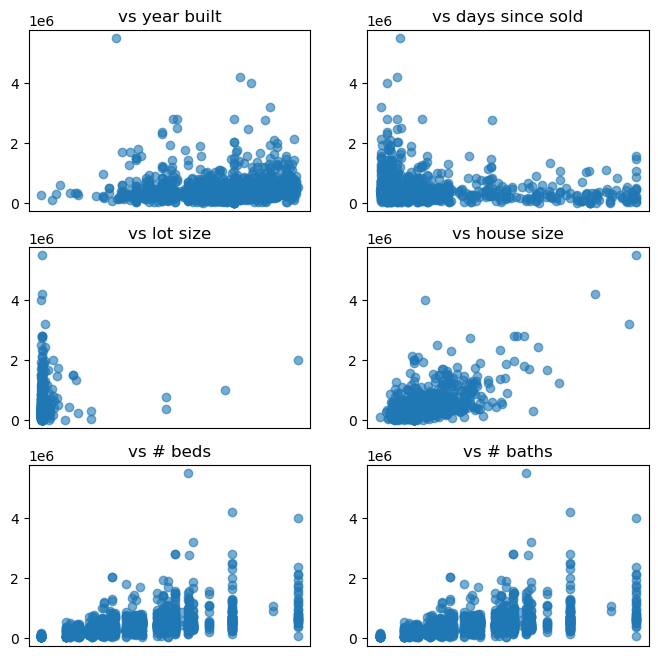

In [ ]:
# plotting some of the interesting variables
use_x = pd.read_pickle('pickles/X_train.pkl')
use_y = pd.read_pickle('pickles/y_train.pkl')

y = use_y
a = use_x['descrip_year_built']
b = use_x['days_since_sold']

c = use_x['descrip_lot_sqft']
d = use_x['descrip_sqft']

e =use_x['state_target_encoded']
f = use_x['state_target_encoded']

g = use_x['descrip_beds']
h = use_x['descrip_baths']


plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.scatter(a,y,alpha=0.6)
plt.xticks([])
plt.title('vs year built')

plt.subplot(3,2,2)
plt.scatter(b,y,alpha=0.6)
plt.xticks([])
plt.title('vs days since sold')

plt.subplot(3,2,3)
plt.scatter(c,y,alpha=0.6)
plt.xticks([])
plt.title('vs lot size')

plt.subplot(3,2,4)
plt.scatter(d,y,alpha=0.6)
plt.xticks([])
plt.title('vs house size')

plt.subplot(3,2,5)
plt.scatter(e,y,alpha=0.6)
plt.xticks([])
plt.title('vs # beds')

plt.subplot(3,2,6)
plt.scatter(f,y,alpha=0.6)
plt.xticks([])
plt.title('vs # baths')


## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

Our scaling is actually in the model notebook. 

Text(0.5, 1.0, 'vs den or office')

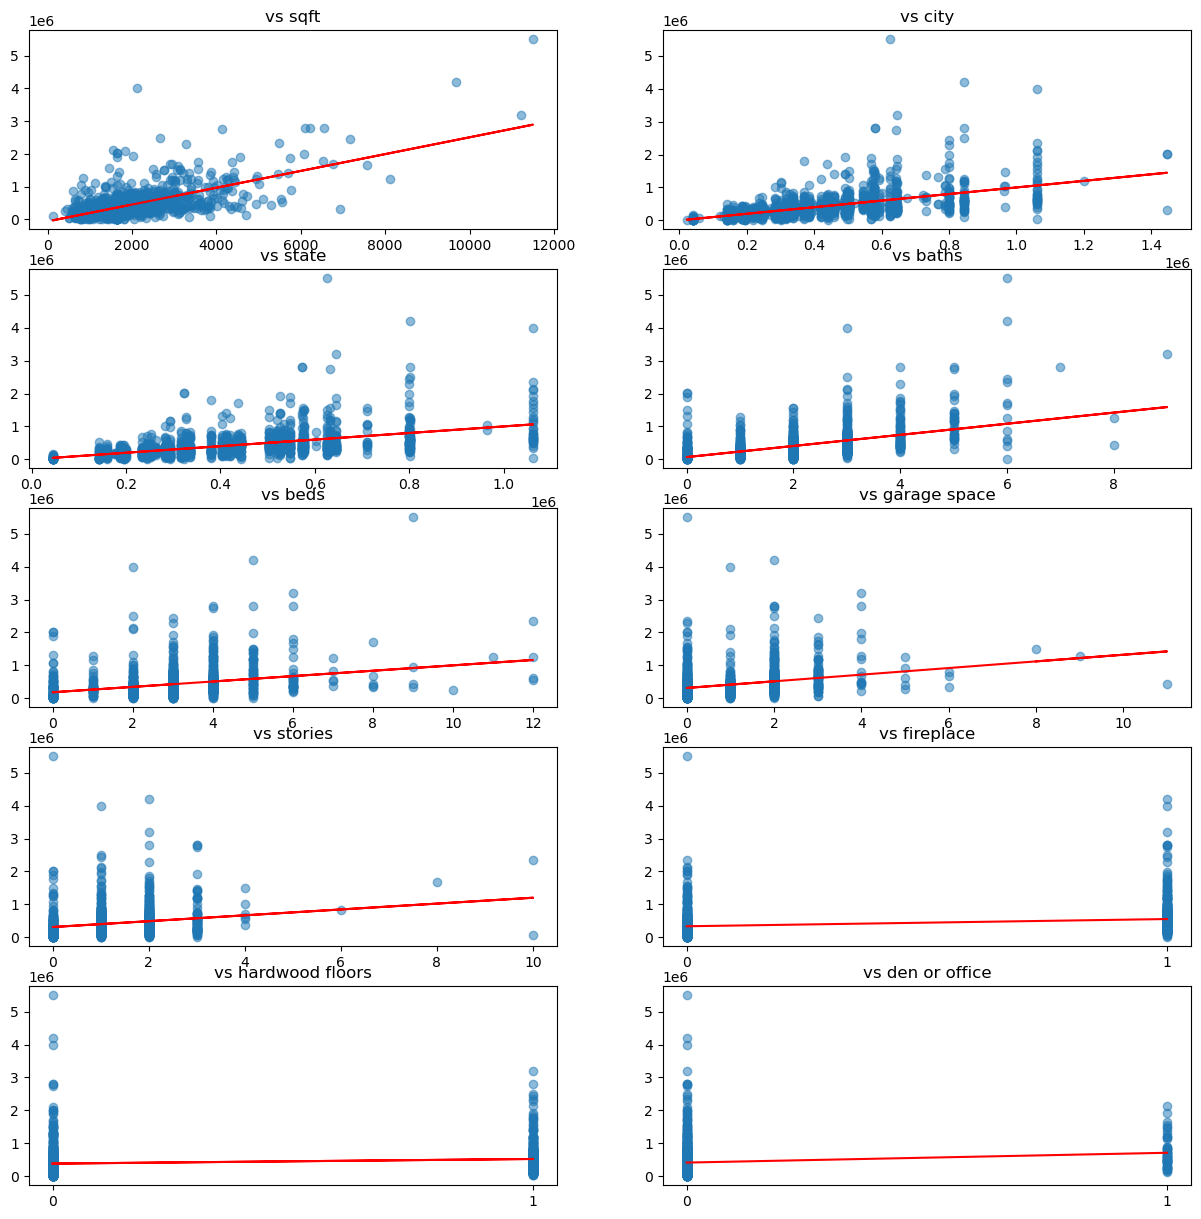

In [139]:
# plotting best fit lines for variables returned as most significant 
y = use_y

plt.figure(figsize=(15,15))
plt.subplot(5,2,1)
a = use_x['descrip_sqft']
k,l = np.polyfit(a,y,1)

plt.scatter(a,y,alpha=0.5)
plt.plot(a,k*a+l,color='red')
plt.title('vs sqft')


plt.subplot(5,2,2)
b = use_x['city_target_encoded']
m,n = np.polyfit(b,y,1)

plt.scatter(b,y,alpha=0.5)
plt.plot(b,m*b+n,color='red')
plt.title('vs city')


plt.subplot(5,2,3)
c = use_x['state_target_encoded']
o,p = np.polyfit(c,y,1)

plt.scatter(c,y,alpha=0.5)
plt.plot(c,o*c+p,color='red')
plt.title('vs state')


plt.subplot(5,2,4)
d = use_x['descrip_baths']
q,r = np.polyfit(d,y,1)

plt.scatter(d,y,alpha=0.5)
plt.plot(d,q*d+r,color='red')
plt.title('vs baths')


plt.subplot(5,2,5)
e = use_x['descrip_beds']
s,t = np.polyfit(e,y,1)

plt.scatter(e,y,alpha=0.5)
plt.plot(e,s*e+t,color='red')
plt.title('vs beds')


plt.subplot(5,2,6)
f = use_x['garage_car_spaces']
u,v = np.polyfit(f,y,1)

plt.scatter(f,y,alpha=0.5)
plt.plot(f,u*f+v,color='red')
plt.title('vs garage space')


plt.subplot(5,2,7)
h = use_x['descrip_stories']
aa,bb = np.polyfit(h,y,1)

plt.scatter(h,y,alpha=0.5)
plt.plot(h,aa*h+bb,color='red')
plt.title('vs stories')


plt.subplot(5,2,8)
g = use_x['fireplace']
w,z = np.polyfit(g,y,1)

plt.scatter(g,y,alpha=0.5)
plt.plot(g,w*g+z,color='red')
plt.xticks(np.arange(0,2,1))
plt.title('vs fireplace')


plt.subplot(5,2,9)
i = use_x['hardwood_floors']
cc,dd = np.polyfit(i,y,1)

plt.scatter(i,y,alpha=0.5)
plt.plot(i,cc*i+dd,color='red')
plt.xticks(np.arange(0,2,1))
plt.title('vs hardwood floors')


plt.subplot(5,2,10)
j = use_x['den_or_office']
ee,ff = np.polyfit(j,y,1)

plt.scatter(j,y,alpha=0.5)
plt.plot(j,ee*j+ff,color='red')
plt.xticks(np.arange(0,2,1))
plt.title('vs den or office')

In [146]:
# combining cleaned/scaled variables to make pairplot 
topair = pd.concat([use_x[['descrip_sqft','city_target_encoded','state_target_encoded','descrip_baths','descrip_beds','garage_car_spaces','descrip_stories','fireplace','hardwood_floors','den_or_office',]],y_train],axis=1)

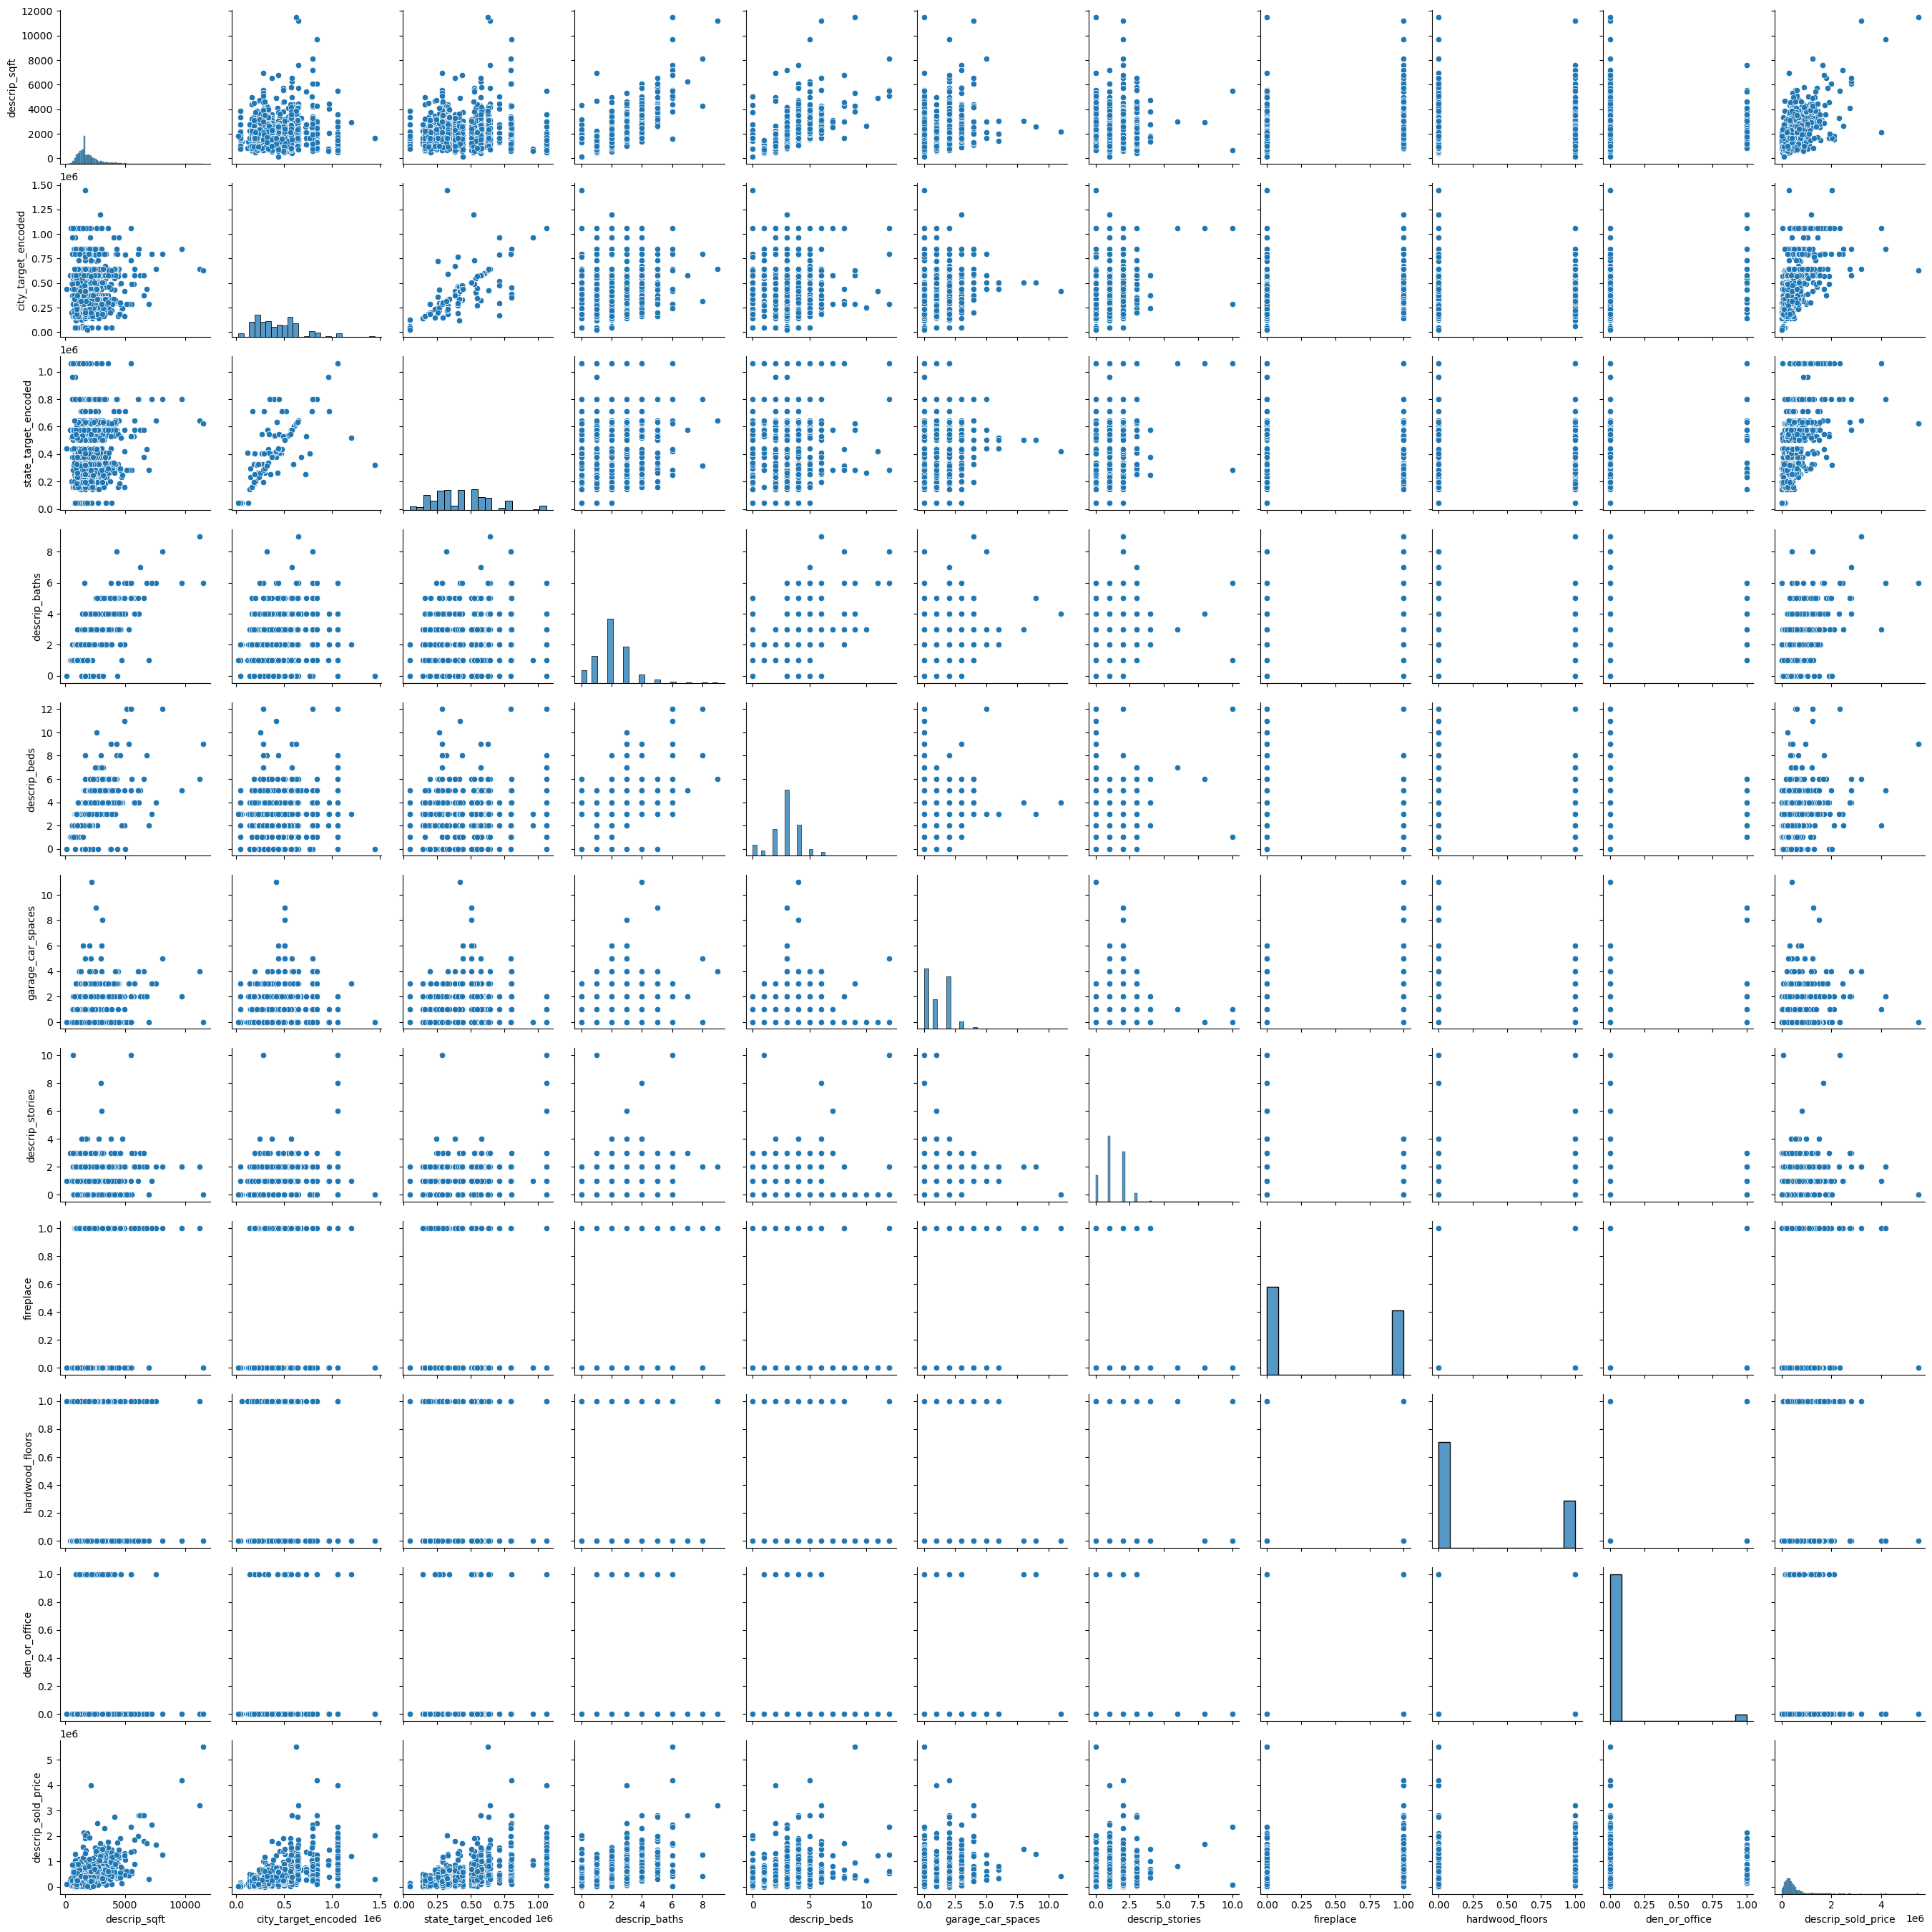

In [148]:
import seaborn as sns
sns.pairplot(topair)